In [1]:
# ref: https://www.kaggle.com/ekami66/detailed-exploratory-data-analysis-with-python

import os, sys
import json
import math
import numpy as np
import pandas as pd
import seaborn as sns
import string
from os.path import join 

%matplotlib inline
import matplotlib.pyplot as plt

from warnings import simplefilter
# ignore all future warnings
simplefilter(action='ignore', category=FutureWarning)

import torch
import torchvision

print("PyTorch Version: ",torch.__version__)
print("Torchvision Version: ",torchvision.__version__)

PyTorch Version:  1.5.1
Torchvision Version:  0.6.1


In [2]:
DataPath = r'D:\GitWork\titanic\data'
OutPath  = r'D:\GitWork\titanic\output'

TrainFile  = 'train.csv'
TestFile   = 'test.csv'
SubmitFile = 'gender_submission.csv'

In [3]:
# Importing the data and displaying some rows
f_abspath = join(DataPath, TrainFile)
df_train = pd.read_csv(f_abspath)

display(df_train.info())
print()
display(df_train.head(10))
print()
display(df_train.describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


None

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
5,6,0,3,"Moran, Mr. James",male,NaN,0,0,330877,8.4583,NaN,Q
6,7,0,1,"McCarthy, Mr. Timothy J",male,54.0,0,0,17463,51.8625,E46,S
7,8,0,3,"Palsson, Master. Gosta Leonard",male,2.0,3,1,349909,21.0750,NaN,S
8,9,1,3,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",female,27.0,0,2,347742,11.1333,NaN,S
9,10,1,2,"Nasser, Mrs. Nicholas (Adele Achem)",female,14.0,1,0,237736,30.0708,NaN,C


,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


Text(0.5, 1.0, 'train feature corr')

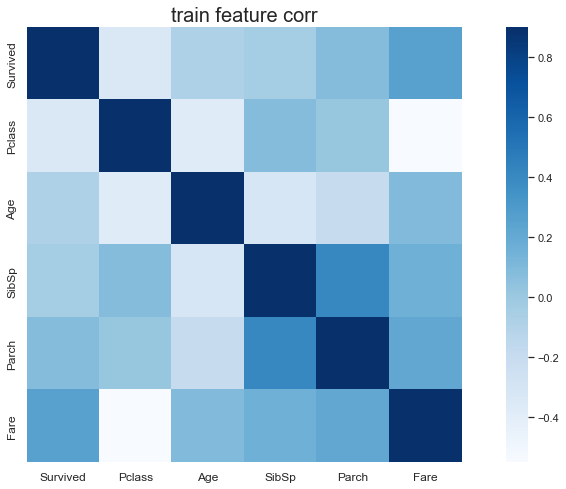

In [4]:
sns.set(context="paper", font="monospace")
sns.set(style="white")

f, ax = plt.subplots(figsize=(16, 8))
train_corr = df_train.drop('PassengerId', axis=1).corr()
sns.heatmap(train_corr, ax=ax, vmax=.9, square=True, cmap="Blues")

font_size = 12
ax.set_xticklabels(train_corr.index, size=font_size)
ax.set_yticklabels(train_corr.columns, size=font_size, va='center') # va = verticalalignment

ax.set_title('train feature corr', fontsize=20)

,Pclass,Survived
0,1,0.630
1,2,0.473
2,3,0.242


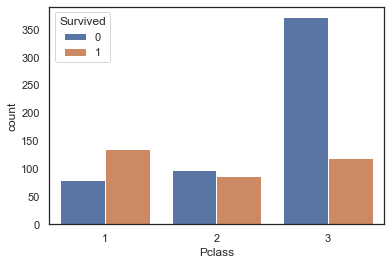

In [5]:
# Observed the relationship between surviced and Pclass
col_idx = 'Pclass'

df_data = df_train[['Pclass', 'Survived']].copy()
sns.countplot(df_data[col_idx], hue=df_data['Survived'])
display(df_data[[col_idx, 'Survived']].groupby([col_idx], as_index=False).mean().round(3))

Survived,0,1
Pclass,,
1,80,136
2,97,87
3,372,119


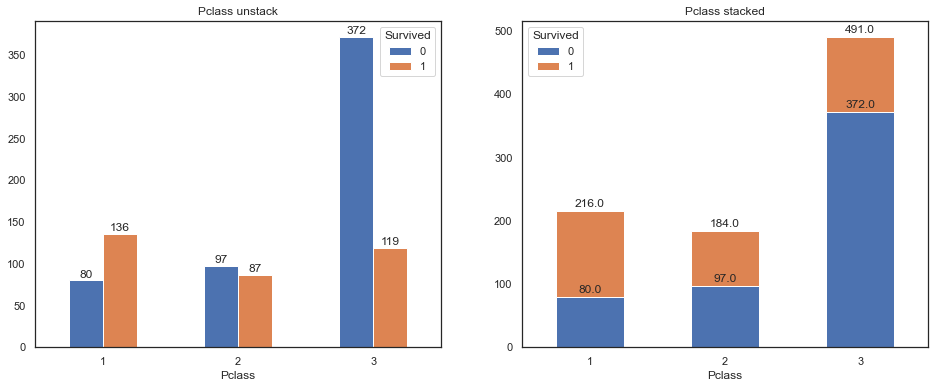

In [6]:
def plotBarStacked(df_plt, ax, title=None):
    ax.set_title('{} stacked'.format(title))
    ax.set_xlabel('')
    df_plt.plot(kind='bar', stacked=True, rot=0, ax=ax)

    for p in ax.patches:
        width = p.get_width()
        height = p.get_height()
        left, bottom = p.get_xy()
        val = bottom + height
        ax.annotate(
            '{}'.format(val),
            xy = (left + width/2, val),
            xytext = (0,2),
            textcoords = "offset points",
            ha = 'center', 
            va = 'bottom'
        )
    return

def plotBarUnstack(df_plt, ax, title):
    ax.set_title('{} unstack'.format(title))
    ax.set_xlabel('')
    df_plt.plot(kind='bar', stacked=False, rot=0, ax=ax)

    for p in ax.patches:
        width = p.get_width()
        height = p.get_height()
        left, bottom = p.get_xy()
        ax.annotate(
            '{}'.format(height),
            xy = (left + width / 2, height),
            xytext = (0, 1),
            textcoords = "offset points",
            ha = 'center', 
            va = 'bottom'
        )
    return

# Method 1
df_pclass = df_train.groupby(['Pclass', 'Survived']).size().reset_index()
df_pclass = df_pclass.pivot(index='Pclass', columns='Survived', values=0)
display(df_pclass)

df_plot = df_pclass
fig, axes = plt.subplots(1, 2, figsize=(16,6))
plotBarUnstack(df_plot, axes[0], 'Pclass')
plotBarStacked(df_plot, axes[1], 'Pclass')
plt.show()

Total Passengers: 891


Survived,dead,alive,Sum,Rate_S1/Pc,Rate_S1/TP
Pclass,,,,,
1,80,136,216,0.630,0.153
2,97,87,184,0.473,0.098
3,372,119,491,0.242,0.134


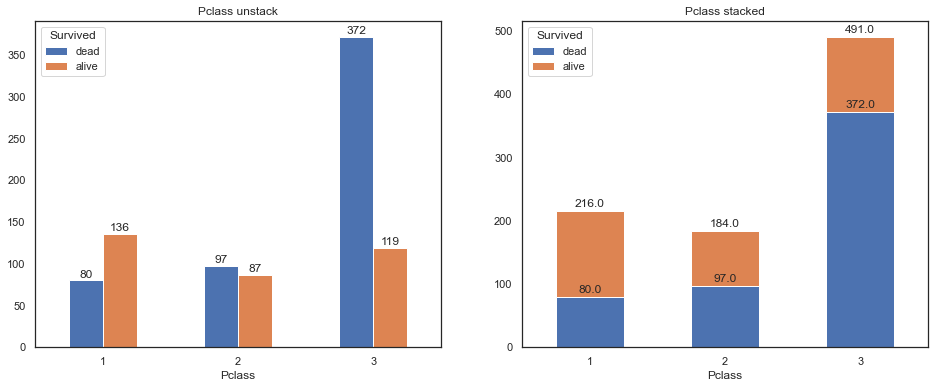

In [7]:
# Method 2
df_pclass = pd.DataFrame({
    'dead' : df_train.Pclass[df_train.Survived==0].value_counts(),
    'alive': df_train.Pclass[df_train.Survived==1].value_counts()
})
df_pclass.index.name = 'Pclass'
df_pclass.columns.name = 'Survived'
# display(df_pclass)

total_passengers = df_pclass.to_numpy().sum()
print('Total Passengers:', total_passengers)

# cnt_dead  = df_pclass['0']
# cnt_alive = df_pclass['1']

df_pclass['Sum'] = df_pclass.sum(axis=1)
df_pclass['Rate_S1/Pc'] = (df_pclass['alive'] / df_pclass['Sum']).round(3)
df_pclass['Rate_S1/TP'] = (df_pclass['alive'] / total_passengers).round(3)

display(df_pclass)

features = ['dead', 'alive']
df_plot = df_pclass[features]
# display(df_plot)

fig, axes = plt.subplots(1, 2, figsize=(16,6))
plotBarUnstack(df_plot, axes[0], 'Pclass')
plotBarStacked(df_plot, axes[1], 'Pclass')
plt.show()

# print(df_plot.columns)
# print(df_plot.columns.name)
# print(df_plot.columns.values)
# print()
# print(df_plot.index)
# print(df_plot.index.name)
# print(df_plot.index.values)

,Sex,Survived
0,female,0.742
1,male,0.189


Sex dict: {'female': 0, 'male': 1}


,PassengerId,Sex,Survived,Sex_code
0,1,male,0,1
1,2,female,1,0
2,3,female,1,0
3,4,female,1,0
4,5,male,0,1


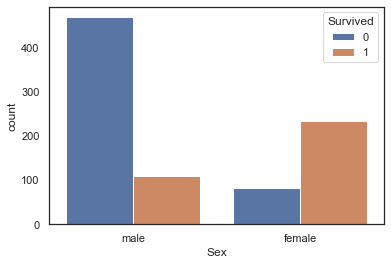

In [8]:
# Observed the relationship between surviced and sex
col_name = 'Sex'
sns.countplot(df_train[col_name], hue=df_train['Survived'])
display(df_train[[col_name, 'Survived']].groupby([col_name], as_index=False).mean().round(3))

uni_sex = sorted(df_train.Sex.unique())
dict_sex = { v: i for i, v in enumerate(uni_sex)}
print('Sex dict:', dict_sex)

features = ['PassengerId', 'Sex', 'Survived']
df_sex = df_train[features].copy()
df_sex['Sex_code'] = df_sex['Sex'].map(dict_sex).astype(int)
display(df_sex.head())

# df_train['Sex_code'] = df_train['Sex'].map(dict_sex).astype(int)
# display(df_train.head())

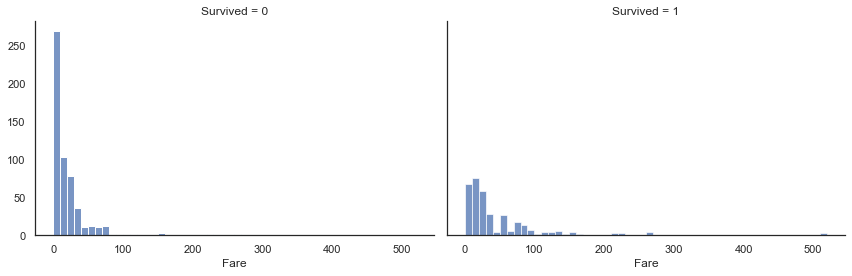

In [9]:
# Observed the relationship between surviced and Fare (船票價格)
col_name = 'Fare'
g = sns.FacetGrid(df_train, col='Survived', height=4, aspect=1.5)
g.map(sns.histplot, col_name, kde=False, binwidth=10)

Fare min: 0
Fare max: 512
bins: [  0  57 114 171 228 285 342 399 456 513]


Survived,dead,alive
Fare_max,,
57,509,255
114,30,55
171,4,18
228,3,6
285,3,5
342,0,0
399,0,0
456,0,0
513,0,3


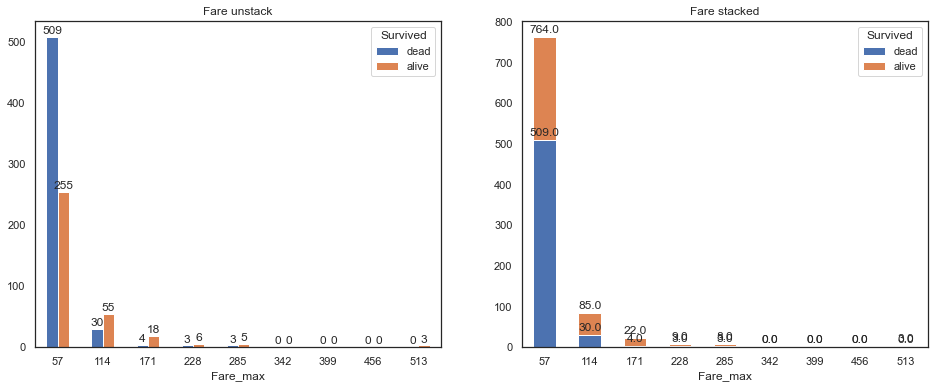

In [10]:
features = ['Survived', 'Fare']
df_data = df_train[features].copy()
# display(df_data)

fare_min = df_data.Fare.min().astype(int)
print('Fare min: {}'.format(fare_min))

fare_max = df_data.Fare.max().astype(int)
print('Fare max: {}'.format(fare_max))

bins = np.linspace(fare_min, fare_max+1, 10, dtype=int)
print('bins:', bins)

cuts = pd.cut(df_data.Fare, bins, right=False)
# display(cuts)

df_data['cuts'] = pd.cut(df_data['Fare'], bins, right=False)
# display(df_data)

df_fare = pd.DataFrame({
    'dead' : df_data.cuts[df_data.Survived==0].value_counts(),
    'alive': df_data.cuts[df_data.Survived==1].value_counts()
})
df_fare.index = bins[1:]
df_fare.index.name = 'Fare_max'
df_fare.columns.name = 'Survived'
display(df_fare)

df_plot = df_fare
fig, axes = plt.subplots(1,2,figsize=(16,6))
plotBarUnstack(df_plot, axes[0], 'Fare')
plotBarStacked(df_plot, axes[1], 'Fare')
plt.show()

In [11]:
features = ['Survived', 'Fare']
df_data = df_train[features].copy()

# There is no fare in the range [300, 400)
bins = [0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 200, 300, 513] 
print('bins:', bins)

df_data['cuts'] = pd.cut(df_data.Fare, bins, right=False)
# display(df_data)

df_fare = pd.DataFrame({
    'S0': df_data.cuts[df_data.Survived==0].value_counts(),
    'S1': df_data.cuts[df_data.Survived==1].value_counts()
})
# df_fare.index = bins[1:]
df_fare.index.name = 'Fare'
df_fare.columns.name = 'Survived'

cnt_alive = df_fare['S1']
cnt_total = df_fare['S0'] + df_fare['S1']
df_fare['fare_surv_rate'] = (cnt_alive / cnt_total).round(3)
# df_fare['fare_survival_rate'].fillna(0, inplace=True)
display(df_fare)

print('Fare survival rate describe:')
display(df_fare['fare_surv_rate'].describe())

bins: [0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 200, 300, 513]


Survived,S0,S1,fare_surv_rate
Fare,,,
"[0, 10)",269,67,0.199
"[10, 20)",103,76,0.425
"[20, 30)",78,58,0.426
"[30, 40)",36,28,0.438
"[40, 50)",11,4,0.267
"[50, 60)",12,27,0.692
"[60, 70)",11,6,0.353
"[70, 80)",12,17,0.586
"[80, 90)",2,13,0.867


Fare survival rate describe:


count    13.000000
mean      0.579462
std       0.251182
min       0.199000
25%       0.425000
50%       0.586000
75%       0.758000
max       1.000000
Name: fare_surv_rate, dtype: float64

bins: [0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 200, 300, 513]


Survived,Bins,S0,S1,fare_surv_rate
Bin_max,,,,
10,"[0, 10)",269,67,0.199
20,"[10, 20)",103,76,0.425
30,"[20, 30)",78,58,0.426
40,"[30, 40)",36,28,0.438
50,"[40, 50)",11,4,0.267
60,"[50, 60)",12,27,0.692
70,"[60, 70)",11,6,0.353
80,"[70, 80)",12,17,0.586
90,"[80, 90)",2,13,0.867


Fare survival rate describe:


count    13.000000
mean      0.579462
std       0.251182
min       0.199000
25%       0.425000
50%       0.586000
75%       0.758000
max       1.000000
Name: fare_surv_rate, dtype: float64

Fare code dict: {'min': 0, '25%': 1, '50%': 2, '75%': 3, 'max': 4}


Survived,Bins,S0,S1,fare_surv_rate,fare_surv_label,fare_surv_code
Bin_max,,,,,,
10,"[0, 10)",269,67,0.199,min,0
20,"[10, 20)",103,76,0.425,25%,1
30,"[20, 30)",78,58,0.426,50%,2
40,"[30, 40)",36,28,0.438,50%,2
50,"[40, 50)",11,4,0.267,25%,1
60,"[50, 60)",12,27,0.692,75%,3
70,"[60, 70)",11,6,0.353,25%,1
80,"[70, 80)",12,17,0.586,50%,2
90,"[80, 90)",2,13,0.867,max,4



{Interval(0, 10, closed='left'): 0, Interval(10, 20, closed='left'): 1, Interval(20, 30, closed='left'): 2, Interval(30, 40, closed='left'): 2, Interval(40, 50, closed='left'): 1, Interval(50, 60, closed='left'): 3, Interval(60, 70, closed='left'): 1, Interval(70, 80, closed='left'): 2, Interval(80, 90, closed='left'): 4, Interval(90, 100, closed='left'): 4, Interval(100, 200, closed='left'): 3, Interval(200, 300, closed='left'): 3, Interval(300, 513, closed='left'): 4}


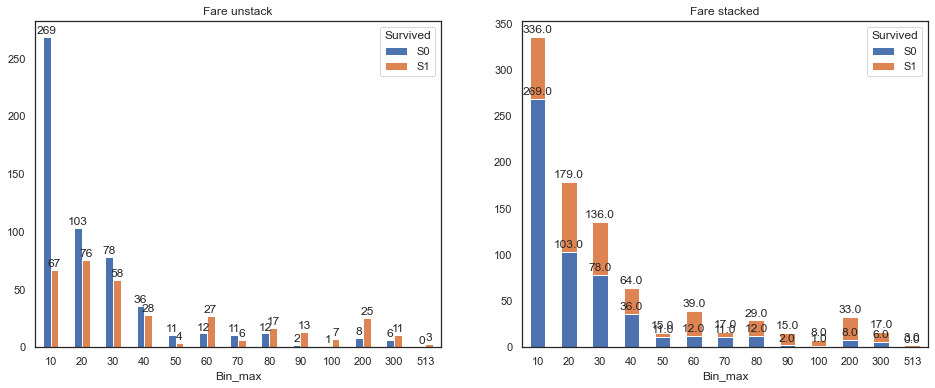

In [12]:
# based on above analysis, we can merge some range that have similar survival rates
features = ['Survived', 'Fare']
df_data = df_train[features].copy()

bins = [0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 200, 300, 513] 
print('bins:', bins)

df_data['Bins'] = pd.cut(df_data['Fare'], bins, right=False)

df_fare = pd.DataFrame({
    'S0' : df_data.Bins[df_data.Survived==0].value_counts(),
    'S1': df_data.Bins[df_data.Survived==1].value_counts()
})

df_fare.insert(0, column='Bins', value=df_fare.index)
df_fare.index = bins[1:]
df_fare.index.name = 'Bin_max'
df_fare.columns.name = 'Survived'

cnt_alive = df_fare['S1']
cnt_total = df_fare['S1'] + df_fare['S0']
df_fare['fare_surv_rate'] = (cnt_alive / cnt_total).round(3)
display(df_fare)

print('Fare survival rate describe:')
display(df_fare['fare_surv_rate'].describe())

# 分成 n區間
fare_bins = [0, 0.199, 0.425, 0.586, 0.758, 1.0]
fare_labels = ['min', '25%', '50%', '75%', 'max']

dict_fare_surv_rate = {v: i  for i, v in enumerate(fare_labels)}
print('Fare code dict:', dict_fare_surv_rate)

df_fare['fare_surv_label'] = pd.cut(
    df_fare['fare_surv_rate'], fare_bins, labels=fare_labels
)
# display(df_fare)

df_fare['fare_surv_code'] = df_fare['fare_surv_label'].map(dict_fare_surv_rate).astype(int)
display(df_fare)

dict_fare = dict(zip(df_fare.Bins, df_fare.fare_surv_code))
print(); print(dict_fare)

features = ['S0', 'S1']
df_plot = df_fare[features]
fig, axes = plt.subplots(1,2,figsize=(16,6))
plotBarUnstack(df_plot, axes[0], 'Fare')
plotBarStacked(df_plot, axes[1], 'Fare')
plt.show()

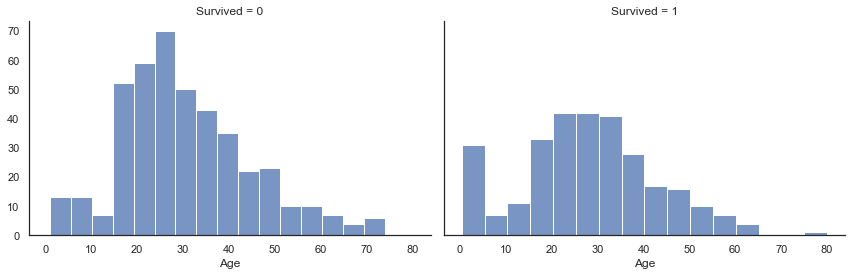

In [13]:
# Observed the relationship between surviced and sex
col_name = 'Age'
g = sns.FacetGrid(df_train, col='Survived', height=4, aspect=1.5)
g.map(sns.histplot, col_name, kde=False)

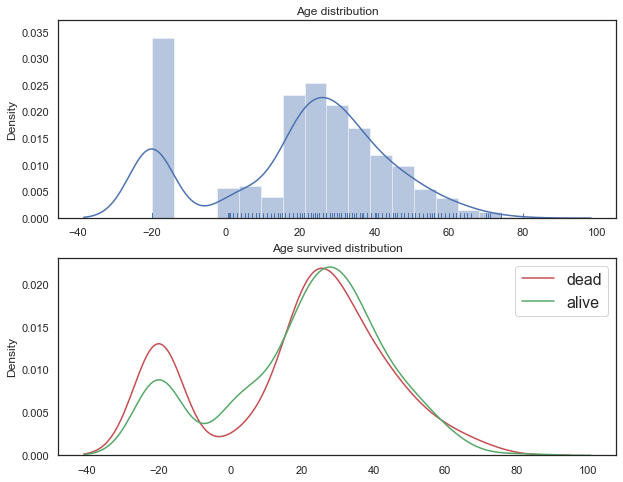

In [14]:
from scipy import stats

def plotDistribution(df):
    fig, axes = plt.subplots(2, 1, figsize=(10, 8))
    sns.set_style('white')
    sns.distplot(df.Age.fillna(-20), rug=True, color='b', ax=axes[0])

    ax0 = axes[0]
    ax0.set_title('Age distribution')
    ax0.set_xlabel('')

    ax1 = axes[1]
    ax1.set_title('Age survived distribution')
    k1 = sns.distplot(df[df.Survived==0].Age.fillna(-20), hist=False, color='r', ax=ax1, label='dead')
    k2 = sns.distplot(df[df.Survived==1].Age.fillna(-20), hist=False, color='g', ax=ax1, label='alive')
    ax1.set_xlabel('')

    ax1.legend(fontsize=16)
    return 

plotDistribution(df_train)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Age          714 non-null    float64
 2   Survived     891 non-null    int64  
dtypes: float64(1), int64(2)
memory usage: 21.0 KB


None

Age
0.42     1
0.67     1
0.75     2
0.83     2
0.92     1
        ..
70.00    2
70.50    1
71.00    2
74.00    1
80.00    1
Name: age_cnt, Length: 88, dtype: int64

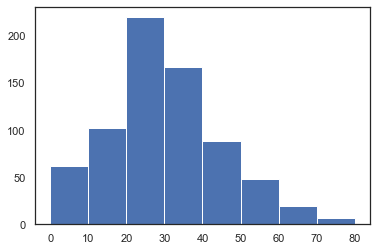

In [15]:
columns=['PassengerId', 'Age', 'Survived']
display(df_train[columns].info())
# display(df_train[columns].describe())

age_series = df_train.groupby('Age')['PassengerId'].size().rename('age_cnt')
display(age_series)

bins = [x for x in range(0, 81, 10)]
plt.hist(df_train['Age'], bins, histtype='bar', rwidth=1)
plt.show()

,SibSp,Survived
0,0,0.345
1,1,0.536
2,2,0.464
3,3,0.250
4,4,0.167
5,5,0.000
6,8,0.000


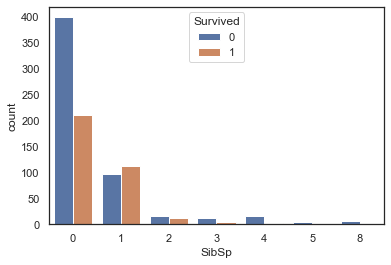

In [16]:
# Observed the relationship between surviced and SibSp (在船上同為兄弟姐妹或配偶的數目)
col_name = 'SibSp'
sns.countplot(df_train[col_name], hue=df_train['Survived'])
display(df_train[[col_name, 'Survived']].groupby([col_name], as_index=False).mean().round(3))

,Parch,Survived
0,0,0.344
1,1,0.551
2,2,0.500
3,3,0.600
4,4,0.000
5,5,0.200
6,6,0.000


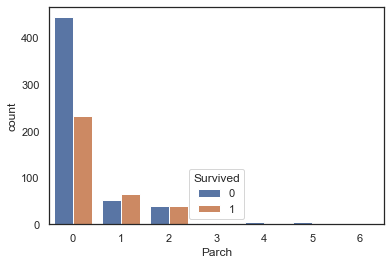

In [17]:
# Observed the relationship between surviced and Parch (在船上同為家族的父母及小孩的數目)
col_name = 'Parch'
sns.countplot(df_train[col_name], hue=df_train['Survived'])
display(df_train[[col_name, 'Survived']].groupby([col_name], as_index=False).mean().round(3))

,Ticket,Survived
0,110152,1.000
1,110413,0.667
2,110465,0.000
3,110564,1.000
4,110813,1.000
...,...,...
676,W./C. 6608,0.000
677,W./C. 6609,0.000
678,W.E.P. 5734,0.000
679,W/C 14208,0.000


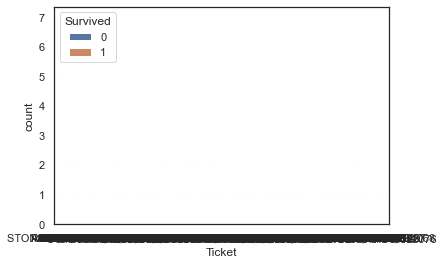

In [18]:
# Observed the relationship between surviced and Ticket
col_name = 'Ticket'
sns.countplot(df_train[col_name], hue=df_train['Survived'])
display(df_train[[col_name, 'Survived']].groupby([col_name], as_index=False).mean().round(3))

count     204
unique    147
top        G6
freq        4
Name: Cabin, dtype: object

,Cabin,Survived
0,A10,0.0
1,A14,0.0
2,A16,1.0
3,A19,0.0
4,A20,1.0
...,...,...
142,F33,1.0
143,F38,0.0
144,F4,1.0
145,G6,0.5


,PassengerId,Cabin,Cabin_0,Cabin_1,Cabin_2,Cabin_3
0,1,NaN,NaN,NaN,NaN,NaN
1,2,C85,C85,None,None,None
2,3,NaN,NaN,NaN,NaN,NaN
3,4,C123,C123,None,None,None
4,5,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...
886,887,NaN,NaN,NaN,NaN,NaN
887,888,B42,B42,None,None,None
888,889,NaN,NaN,NaN,NaN,NaN
889,890,C148,C148,None,None,None


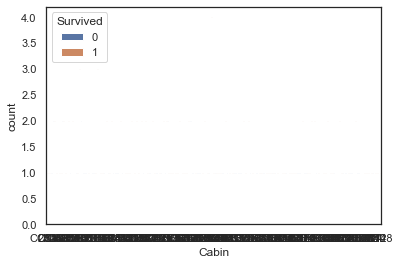

In [19]:
# Observed the relationship between surviced and Carbin (船艙號碼)
col_name = 'Cabin'
display(df_train[col_name].describe())

sns.countplot(df_train[col_name], hue=df_train['Survived'])
display(df_train[[col_name, 'Survived']].groupby([col_name], as_index=False).mean().round(3))

# Split Cabin column to multiple sub cabins
# columns = ['PassengerId', 'Cabin']
# df_cabins = df_train[columns].copy()
# df_cabins = df_cabins.join(df_cabins['Cabin'].str.split(' ', expand=True).add_prefix('Cabin_'))
# display(df_cabins)

,Embarked,Survived
0,C,0.554
1,Q,0.390
2,S,0.337


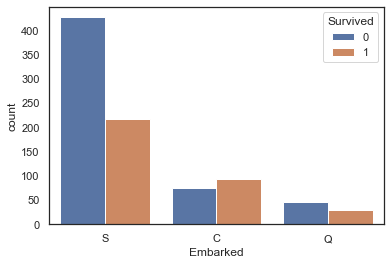

In [20]:
# Observed the relationship between surviced and Embarked (登船的口岸)
# C = Cherbourg, Q = Queenstown and S = Southampton
#
col_name = 'Embarked'
sns.countplot(df_train[col_name], hue=df_train['Survived'])
display(df_train[[col_name, 'Survived']].groupby([col_name], as_index=False).mean().round(3))

In [21]:
# Fill null embarked values
#
# print rows that embarked value is NaN
col_name = 'Embarked'
indexes = df_train[df_train[col_name].isnull()].index.tolist()
display(df_train.loc[indexes])

# old dataframe groupby column to create a new dataframe
# df_embark = df_train.groupby('Embarked')['PassengerId'].size().rename('count').reset_index()
# print(type(df_embark))

df_embark = df_train.groupby('Embarked')['PassengerId'].size().rename('count').reset_index()
display(df_embark)

embark_len = df_embark['count'].sum()
paseng_len = len(df_train['PassengerId'])
print('Embarked size:', embark_len)
print('Passenger size:', paseng_len)

# # The most people embarked from 'S', therefore set the null values as 'S'
df_train['Embarked'].fillna('S', inplace=True)

columns = ['PassengerId', 'Embarked']
print(); display(df_train[columns].info())

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
61,62,1,1,"Icard, Miss. Amelie",female,38.0,0,0,113572,80.0,B28,NaN
829,830,1,1,"Stone, Mrs. George Nelson (Martha Evelyn)",female,62.0,0,0,113572,80.0,B28,NaN


,Embarked,count
0,C,168
1,Q,77
2,S,644


Embarked size: 889
Passenger size: 891

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   PassengerId  891 non-null    int64 
 1   Embarked     891 non-null    object
dtypes: int64(1), object(1)
memory usage: 14.0+ KB


None

In [22]:
from sklearn import preprocessing
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor

# Extract training columns
features = ['PassengerId', 'Survived', 'Pclass', 'Fare', 'Sex']

# Mapping Sex to Sex_code
df1 = df_train[features].copy()
df1['Sex_code'] = df1['Sex'].map(dict_sex).astype(int)
display(df1.info())
display(df1.head())

# Training 1
features = ['Sex_code','Pclass']
inps = df1.filter(features, axis=1)
lbls = df1['Survived']

rf_model = RandomForestClassifier(
    random_state=2, n_estimators=250, min_samples_split=20, oob_score=True
)

rf_model.fit(inps, lbls)
print('oob score :%.5f' %(rf_model.oob_score_))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Fare         891 non-null    float64
 4   Sex          891 non-null    object 
 5   Sex_code     891 non-null    int32  
dtypes: float64(1), int32(1), int64(3), object(1)
memory usage: 38.4+ KB


None

,PassengerId,Survived,Pclass,Fare,Sex,Sex_code
0,1,0,3,7.2500,male,1
1,2,1,1,71.2833,female,0
2,3,1,3,7.9250,female,0
3,4,1,1,53.1000,female,0
4,5,0,3,8.0500,male,1


oob score :0.73176


In [23]:
# Prediction

# Convert Sex to Sex_code
f_abspath = join(DataPath, TestFile)
df_test = pd.read_csv(f_abspath)

# Mapping Sex to Sex_code
df_test['Sex_code'] = df_test['Sex'].map(dict_sex).astype(int)

# Extract test columns
features = ['Sex_code','Pclass']
inps = df_test.filter(features, axis=1)
display(inps.info())

predis = rf_model.predict(inps)

df_res = pd.DataFrame({
    'PassengerId': df_test['PassengerId'].tolist(),
    'Survived': predis.astype(int)
})
display(df_res.info())

f_abspath = join(OutPath, 'Submission01.csv')
df_res.to_csv(f_abspath, index=False)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype
---  ------    --------------  -----
 0   Sex_code  418 non-null    int32
 1   Pclass    418 non-null    int64
dtypes: int32(1), int64(1)
memory usage: 5.0 KB


None

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype
---  ------       --------------  -----
 0   PassengerId  418 non-null    int64
 1   Survived     418 non-null    int32
dtypes: int32(1), int64(1)
memory usage: 5.0 KB


None

In [24]:
# Training 2
features = ['PassengerId', 'Survived', 'Pclass', 'Fare', 'Sex']
df2 = df_train[features].copy()
df2['Sex_code'] = df2['Sex'].map(dict_sex).astype(int)

# Mapping Fare to Fare_code
bins_fare = [0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 200, 300, 513] 
df2['Fare_code'] = pd.cut(df2['Fare'], bins_fare, right=False).map(dict_fare).astype(int)
display(df2)

features = ['Sex_code', 'Pclass', 'Fare_code']
inps = df2.filter(features, axis=1)
lbls = df2['Survived']

rf_model = RandomForestClassifier(
    random_state=2, n_estimators=250, min_samples_split=20, oob_score=True
)

rf_model.fit(inps, lbls)
print('oob score :%.5f' %(rf_model.oob_score_))

,PassengerId,Survived,Pclass,Fare,Sex,Sex_code,Fare_code
0,1,0,3,7.2500,male,1,0
1,2,1,1,71.2833,female,0,2
2,3,1,3,7.9250,female,0,0
3,4,1,1,53.1000,female,0,3
4,5,0,3,8.0500,male,1,0
...,...,...,...,...,...,...,...
886,887,0,2,13.0000,male,1,1
887,888,1,1,30.0000,female,0,2
888,889,0,3,23.4500,female,0,2
889,890,1,1,30.0000,male,1,2


oob score :0.80135


In [25]:
# Prediction
#
# Convert Sex to Sex_code
f_abspath = join(DataPath, TestFile)
df_test = pd.read_csv(f_abspath)
# display(df_test.info())

# Fill null fares
df_test['Fare'].fillna(df_test['Fare'].mean(), inplace=True)
# display(df_test.info())
# display(df_test.describe())

# Mapping Sex to Sex_code
df_test['Sex_code'] = df_test['Sex'].map(dict_sex).astype(int)
df_test['Fare_code'] = pd.cut(df_test['Fare'], bins_fare, right=False).map(dict_fare).astype(int)
# display(df_test)

# Extract test columns
features = ['Sex_code','Pclass','Fare_code']
inps = df_test.filter(features, axis=1)
display(inps.info())

predis = rf_model.predict(inps)

df_res = pd.DataFrame({
    'PassengerId': df_test['PassengerId'].tolist(),
    'Survived': predis.astype(int)
})
display(df_res.info())

f_abspath = join(OutPath, 'Submission02.csv')
df_res.to_csv(f_abspath, index=False)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype
---  ------     --------------  -----
 0   Sex_code   418 non-null    int32
 1   Pclass     418 non-null    int64
 2   Fare_code  418 non-null    int32
dtypes: int32(2), int64(1)
memory usage: 6.7 KB


None

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype
---  ------       --------------  -----
 0   PassengerId  418 non-null    int64
 1   Survived     418 non-null    int32
dtypes: int32(1), int64(1)
memory usage: 5.0 KB


None

In [26]:
print('done')

done
